In [43]:
#Bibliotecas utilizadas
using Plots
using DataFrames
using GLM
using StatsBase
using Statistics
using StatsPlots
using CSV
using Lathe
using MLBase

# Previsão de preços de casas nos Estados Unidos

Feito como exercício para análise de dados. Estou fazendo em Julia por que é uma linguagem muito prática quando se pega o jeito e como eu tenho visto muitos códigos nesse linguagem recentemente quero exercitar. Dataset do Kaggle.

In [44]:
# Importanto os dados e renomeando as colunas para português
df = DataFrame(CSV.File("./housing_price_dataset.csv"))
cols = ["PésQuad", "Quartos", "Banheiros", "Bairro", "AnoConstrucao", "Preço"]
rename!(df, cols)

describe(df)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,PésQuad,2006.37,1000,2007.0,2999,0,Int64
2,Quartos,3.4987,2,3.0,5,0,Int64
3,Banheiros,1.99542,1,2.0,3,0,Int64
4,Bairro,,Rural,,Urban,0,String7
5,AnoConstrucao,1985.4,1950,1985.0,2021,0,Int64
6,Preço,2.24827e5,-36588.2,2.25052e5,4.92195e5,0,Float64


# Tratando Dados

## Tratando bairros
Os bairros no DataFrame estão como strings, quero mudar para valores numéricos para poder trabalhar com eles também. 

Mudei os valores como demonstrado no código abaixo.

In [45]:
value_map = Dict(
    "Rural" => -1,
    "Suburb" => 0,
    "Urban"  => 1
)

df[!, "Bairro"] = [value_map[item] for item in df.Bairro]

50000-element Vector{Int64}:
 -1
 -1
  0
  1
  0
  0
  0
 -1
  1
  1
  0
  0
  0
  ⋮
  0
  0
  0
  0
 -1
  1
  1
 -1
  0
  0
 -1
 -1

-1: 16676
0: 16721
1: 16603


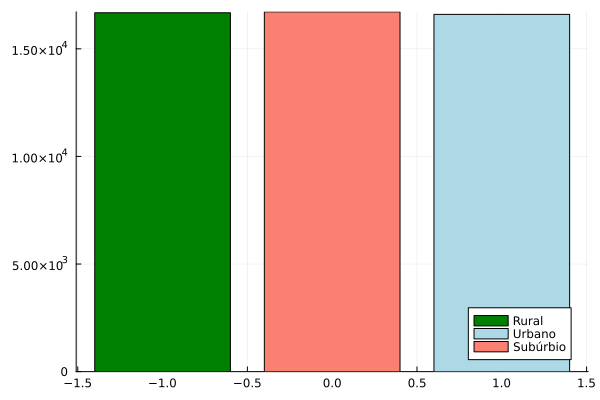

In [46]:
#Parecem estar em proporções iguais ou muito próximas, vamos checar
for i in [-1 0 1]
    println("$i: ", count(f->(f==i), df.Bairro))
end

#Quantidade de cada um dos 'bairros' no dataframe
bar(
    [-1],
    [count(i->(i==-1), df.Bairro)], 
    label="Rural",
    color=:green
)

bar!(
    [1],
    [count(i->(i==1), df.Bairro)], 
    label="Urbano",
    color=:lightblue
)

bar!(
    [0],
    [count(i->(i==0), df.Bairro)], 
    label="Subúrbio",
    color=:salmon
)



## Tratando preços

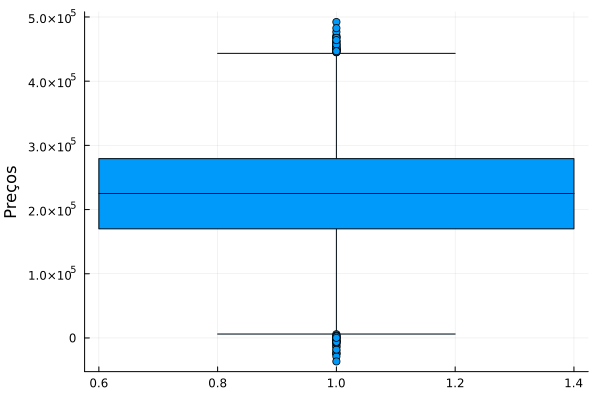

In [47]:
boxplot(df.Preço, ylabel="Preços", leg=false)

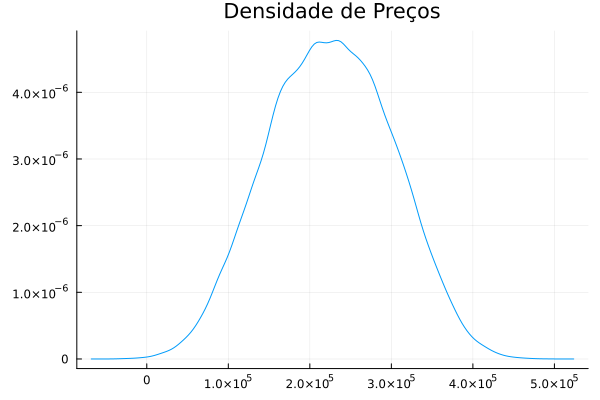

In [48]:
density(df.Preço, leg=false, title="Densidade de Preços")
#Parece seguir uma distribuição normal também

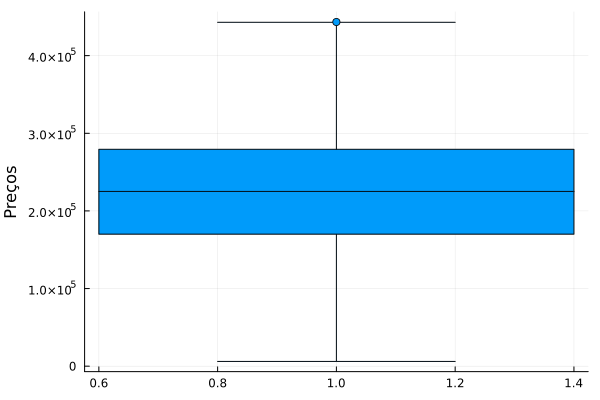

In [49]:
#Removendo outliers
Q1 = percentile(df.Preço, 25)
Q3 = percentile(df.Preço, 75)
iqr_value = iqr(df.Preço) #distância inter quartil
df = df[df.Preço .>  (Q1 - 1.5*iqr_value),:]
df = df[df.Preço .<  (Q3 + 1.5*iqr_value),:]

boxplot(df.Preço, ylabel="Preços", leg=false)
#Melhor agora

# Análise

In [50]:
for nome in names(df)
    println("Correlação de Pearson entre Preço e $nome: $(cor(df.Preço, df[!, nome]))")
end
println()
println("A maior relação é entre o tamanho da casa, o que era esperado.\nO que me surpreendeu foi o ano de construção ter um impacto tão pequeno")


Correlação de Pearson entre Preço e PésQuad: 0.7504617002064365
Correlação de Pearson entre Preço e Quartos: 0.07249954370263065
Correlação de Pearson entre Preço e Banheiros: 0.027849158596873175
Correlação de Pearson entre Preço e Bairro: 0.016371913189325068
Correlação de Pearson entre Preço e AnoConstrucao: -0.002035445364409656
Correlação de Pearson entre Preço e Preço: 1.0

A maior relação é entre o tamanho da casa, o que era esperado.
O que me surpreendeu foi o ano de construção ter um impacto tão pequeno


In [51]:
# Separando dados entre testes e treinamento
using Lathe.preprocess: TrainTestSplit
train, test = TrainTestSplit(df, .75)

# Fazendo regressão linear para previsões de preço
fm0 = @formula(Preço ~ PésQuad)
reglin0 = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Preço ~ 1 + PésQuad + Quartos + Banheiros

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.   Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  2661.04    1377.75        1.93    0.0534   -39.3857  5361.46
PésQuad        99.0505     0.444908  222.63    <1e-99    98.1784    99.9225
Quartos      5114.21     229.437      22.29    <1e-99  4664.51    5563.91
Banheiros    2679.07     313.547       8.54    <1e-16  2064.51    3293.63
───────────────────────────────────────────────────────────────────────────

In [52]:
#Quanto maior melhor
r2(reglin0)

0.5717466247058748

In [53]:
fm = @formula(Preço ~ PésQuad + Quartos + Banheiros)
reglin = lm(fm, train)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Preço ~ 1 + PésQuad + Quartos + Banheiros

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.   Std. Error       t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  2661.04    1377.75        1.93    0.0534   -39.3857  5361.46
PésQuad        99.0505     0.444908  222.63    <1e-99    98.1784    99.9225
Quartos      5114.21     229.437      22.29    <1e-99  4664.51    5563.91
Banheiros    2679.07     313.547       8.54    <1e-16  2064.51    3293.63
───────────────────────────────────────────────────────────────────────────

In [54]:
# Quase igual ao anteriror então vou usar esse
r2(reglin)

0.5717466247058748

In [55]:
# Previsão
yprev_test = predict(reglin, test)
yprev_train = predict(reglin, train)

# Dataframe de performance do Teste
performance_testdf = DataFrame(y_atual = test[!,"Preço"], yprev = yprev_test)
performance_testdf.error = performance_testdf[!,"y_atual"] - performance_testdf[!,"yprev"]
performance_testdf.error_sq = performance_testdf.error .* performance_testdf.error

# Dataframe de performance do Treino
performance_traindf = DataFrame(y_atual = train[!,"Preço"], yprev = yprev_train)
performance_traindf.error = performance_traindf[!,"y_atual"] - performance_traindf[!,"yprev"]
performance_traindf.error_sq = performance_traindf.error .* performance_traindf.error ;

In [58]:
println("Erro médio absoluto Test: ", mean(abs.(performance_testdf.error)))
println("Erro médio quadrático Test: ", mean(performance_testdf.error_sq))

Erro médio absoluto Test: 40114.75914683674
Erro médio quadrático Test: 2.495355791868854e9


In [59]:
println("Erro médio absoluto Treino: ", mean(abs.(performance_traindf.error)))
println("Erro médio quadrático Treino: ", mean(performance_traindf.error_sq))

Erro médio Treino: 39669.22653787121
Erro médio quadrático Treino: 2.4617251783113794e9


# Conclusão

O erro parece ser muito grande para ser confiável, apesar de várias outras métricas terem feito parecer que seria um bom aproximador, talvez o fato de estar trabalhando com números relativamente grandes (preços de casas) deixe esse erro grande. Ao mesmo tempo, é a primeira vez que eu mexo com essas coisas e não sei se esse erro é normal. De qualquer maneira, para fazer alguma previsão é só rodar um código nesse tipo:

$$
predict(reglin, ::VectorFloat64)

$$
em que:

$$
::Vector64 = \{PésQuad\quad Quartos\quad Banheiros\quad c0\}\\
lenght(vet) = 4

$$

In [78]:
#Exemplo
vet = [100 2 3 4]
predict(reglin, vet)

1-element Vector{Float64}:
 292360.92336999474